### Quick Start

The `ssms` package serves two purposes. 

1. Easy access to *fast simulators of sequential sampling models*
   
2. Support infrastructure to construct training data for various approaches to likelihood / posterior amortization

We provide two minimal examples here to illustrate how to use each of the two capabilities.


#### Install 

Let's start with *installing* the `ssms` package.

You can do so by typing,

`pip install ssm-simulators`

in your terminal.

Below you find a basic tutorial on how to use the package.

#### Tutorial

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import ssms

#### Using the Simulators

Let's start with using the basic simulators. 
You access the main simulators through the  `ssms.basic_simulators.simulator.simulator()` function.

To get an idea about the models included in `ssms`, use the `config` module.
The central dictionary with metadata about included models sits in `ssms.config.model_config`. 

In [2]:
# Check included models
list(ssms.config.model_config.keys())[:10]

['ddm',
 'ddm_legacy',
 'angle',
 'weibull',
 'levy',
 'levy_angle',
 'full_ddm',
 'full_ddm_rv',
 'ddm_st',
 'ddm_truncnormt']

In [3]:
# Take an example config for a given model
ssms.config.model_config["ddm"]

{'name': 'ddm',
 'params': ['v', 'a', 'z', 't'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]],
 'boundary_name': 'constant',
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t: float | numpy.ndarray = 0) -> float | numpy.ndarray>,
 'boundary_params': [],
 'n_params': 4,
 'default_params': [0.0, 1.0, 0.5, 0.001],
 'nchoices': 2,
 'n_particles': 1,
 'simulator': <cyfunction ddm_flexbound at 0x12f722e90>}

**Note:**
The usual structure of these models includes,

- Parameter names (`'params'`)
- Bounds on the parameters (`'param_bounds'`)
- A function that defines a boundary for the respective model (`'boundary'`)
- The number of parameters (`'n_params'`)
- Defaults for the parameters (`'default_params'`)
- The number of choices the process can produce (`'nchoices'`)

The `'hddm_include'` key concerns information useful for integration with the [hddm](https://github.com/hddm-devs/hddm) python package, which facilitates hierarchical bayesian inference for sequential sampling models. It is not important for the present tutorial.

In [15]:
from ssms.basic_simulators.simulator import simulator

sim_out = simulator(
    model="shrink_spot_simple_extended",
    theta={
        "a": 0.7,
        "z": 0.5,
        "t": 0.5,
        "ptarget": -5,
        "pouter": 5,
        "r": 0.01,
        "sda": 1,
    },
    n_samples=10000,
)

sim_out2 = simulator(
    model="shrink_spot_simple_extended",
    theta={
        "a": 0.7,
        "z": 0.5,
        "t": 0.5,
        "ptarget": 5,
        "pouter": -5,
        "r": 0.01,
        "sda": 1,
    },
    n_samples=10000,
)

{'a': array([0.7], dtype=float32), 'z': array([0.5], dtype=float32), 't': array([0.5], dtype=float32), 'ptarget': array([-5.], dtype=float32), 'pouter': array([5.], dtype=float32), 'r': array([0.01], dtype=float32), 'sda': array([1.], dtype=float32), 'deadline': array([999.], dtype=float32), 's': array([1.], dtype=float32), 'v': array([0.], dtype=float32)}
{'boundary_params': {}, 'boundary_fun': <function constant at 0x10fdf2680>, 'boundary_multiplicative': True}
{'drift_fun': <function attend_drift_simple at 0x12fb9c4c0>, 'drift_params': {'ptarget': array([-5.], dtype=float32), 'pouter': array([5.], dtype=float32), 'r': array([0.01], dtype=float32), 'sda': array([1.], dtype=float32)}}
{'n_samples': 10000, 'delta_t': 0.001, 'max_t': 20, 'smooth_unif': True, 'return_option': 'full', 'random_state': None, 'n_trials': 1}
{'name': 'shrink_spot_simple_extended', 'params': ['a', 'z', 't', 'ptarget', 'pouter', 'r', 'sda'], 'param_bounds': [[0.3, 0.1, 0.001, 2.0, -5.5, 0.01, 1], [3.0, 0.9, 2.0

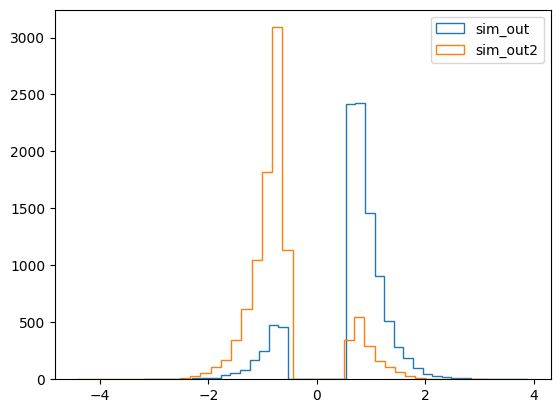

In [16]:
from matplotlib import pyplot as plt

plt.hist(sim_out["rts"] * sim_out["choices"], histtype="step", bins=40, label="sim_out")
plt.hist(
    sim_out2["rts"] * sim_out2["choices"], histtype="step", bins=40, label="sim_out2"
)
plt.legend()

The output of the simulator is a `dictionary` with three elements.

1. `rts` (array)
2. `choices` (array)
3. `metadata` (dictionary)

The `metadata` includes the named parameters, simulator settings, and more.

#### Using the Training Data Generators

The training data generators sit on top of the simulator function to turn raw simulations into usable training data for training machine learning algorithms aimed at posterior or likelihood armortization.

We will use the `data_generator` class from `ssms.dataset_generators`. Initializing the `data_generator` boils down to supplying two configuration dictionaries.

1. The `generator_config`, concerns choices as to what kind of training data one wants to generate.
2. The `model_config` concerns choices with respect to the underlying generative *sequential sampling model*. 

We will consider a basic example here, concerning data generation to prepare for training [LANs](https://elifesciences.org/articles/65074).

Let's start by peeking at an example `generator_config`.

In [5]:
ssms.config.data_generator_config["lan"]

{'output_folder': 'data/lan_mlp/',
 'model': 'ddm',
 'nbins': 0,
 'n_samples': 100000,
 'n_parameter_sets': 10000,
 'n_parameter_sets_rejected': 100,
 'n_training_samples_by_parameter_set': 1000,
 'max_t': 20.0,
 'delta_t': 0.001,
 'pickleprotocol': 4,
 'n_cpus': 'all',
 'kde_data_mixture_probabilities': [0.8, 0.1, 0.1],
 'simulation_filters': {'mode': 20,
  'choice_cnt': 0,
  'mean_rt': 17,
  'std': 0,
  'mode_cnt_rel': 0.95},
 'negative_rt_cutoff': -66.77497,
 'n_subruns': 10,
 'bin_pointwise': False,
 'separate_response_channels': False,
 'smooth_unif': True}

You usually have to make just few changes to this basic configuration dictionary.
An example below.

In [6]:
from copy import deepcopy

# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["dgp_list"] = "angle"
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 100
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 1000

Now let's define our corresponding `model_config`.

In [7]:
model_config = ssms.config.model_config["angle"]
print(model_config)

{'name': 'angle', 'params': ['v', 'a', 'z', 't', 'theta'], 'param_bounds': [[-3.0, 0.3, 0.1, 0.001, -0.1], [3.0, 3.0, 0.9, 2.0, 1.3]], 'boundary_name': 'angle', 'boundary': <function angle at 0x1328dec20>, 'n_params': 5, 'default_params': [0.0, 1.0, 0.5, 0.001, 0.0], 'nchoices': 2, 'n_particles': 1, 'simulator': <cyfunction ddm_flexbound at 0x14096ae90>}


We are now ready to initialize a `data_generator`, after which we can generate training data using the `generate_data_training_uniform` function, which will use the hypercube defined by our parameter bounds from the `model_config` to uniformly generate parameter sets and corresponding simulated datasets.

In [8]:
my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
    generator_config=generator_config, model_config=model_config
)

n_cpus used:  12
checking:  data/lan_mlp/


In [18]:
training_data = my_dataset_generator.generate_data_training_uniform(save=False)

simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10


`training_data` is a dictionary containing four keys:

1. `data` the features for [LANs](https://elifesciences.org/articles/65074), containing vectors of *model parameters*, as well as *rts* and *choices*.
2. `labels` which contain approximate likelihood values
3. `generator_config`, as defined above
4. `model_config`, as defined above

You can now use this training data for your purposes. If you want to train [LANs](https://elifesciences.org/articles/65074) yourself, you might find the [LANfactory](https://github.com/AlexanderFengler/LANfactory) package helpful.

You may also simply find the basic simulators provided with the **ssms** package useful, without any desire to use the outputs into training data for amortization purposes.

##### END